## Simulating a dynamical system using a physics-informed neural network

In [1]:
# ---------------------------------------------------------------------------*/
# - import necessary python packages

import numpy as np
from matplotlib import pyplot as plt

import torch

import function as fun

In [2]:
# ---------------------------------------------------------------------------*/
# - configure an under-damped harmonic oscillator

def osc_true(d, w0, t):
    """Compute an analytical solution to an under-damped harmonic oscillator problem."""
    assert d < w0

    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos

    return u

d, w0 = 2., 2*torch.pi*50
mu, k = 2*d, w0**2

# specify number of points
test_n = 500
phys_n = 300

t_test = torch.linspace(0., 1., test_n).view(-1, 1) # time points for testing
t_init = torch.zeros([1, 1], requires_grad=True) # time point to check initial conditions
t_phys = torch.linspace(0., 1., phys_n, requires_grad=True).view(-1, 1) # time points to check physics

# response of a true harmonic oscillator
u_true = osc_true(d, w0, t_test)

In [3]:
# ---------------------------------------------------------------------------*/
# - neural network for simulation

# preset random number generator to get reproducible results
torch.manual_seed(123)

pinn = fun.neuralnetwork.build(
    features=[1, 16, 16, 1],
    activations=[(torch.nn.Tanh, True), (torch.nn.Tanh, True), (torch.nn.Identity, False)])

pinn.print()

fcnn(
  (_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=False)
      (1): Identity()
    )
  )
)


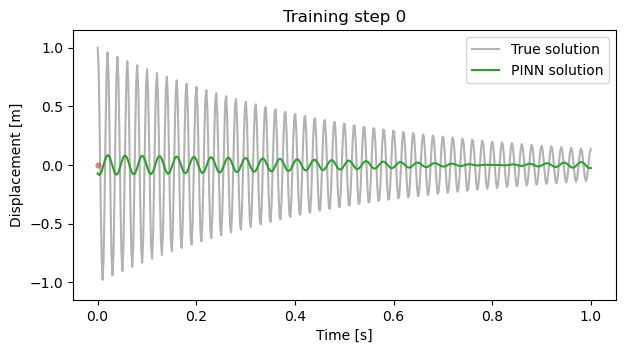

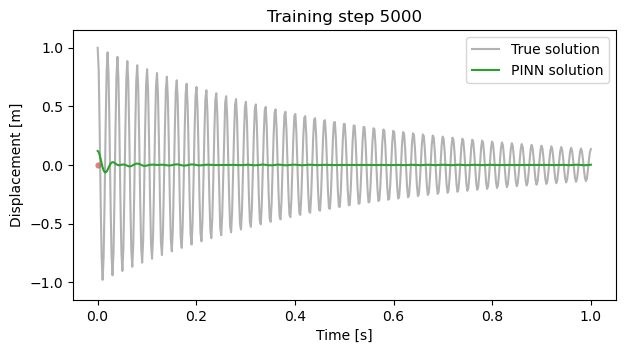

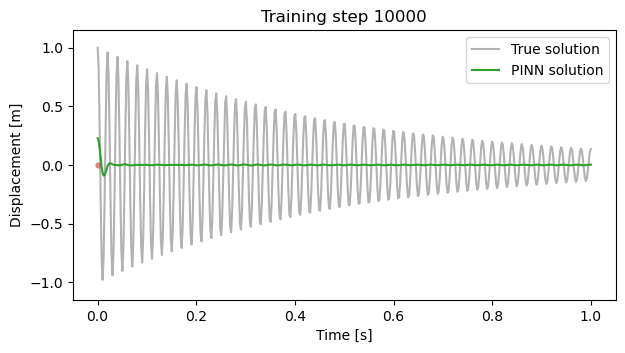

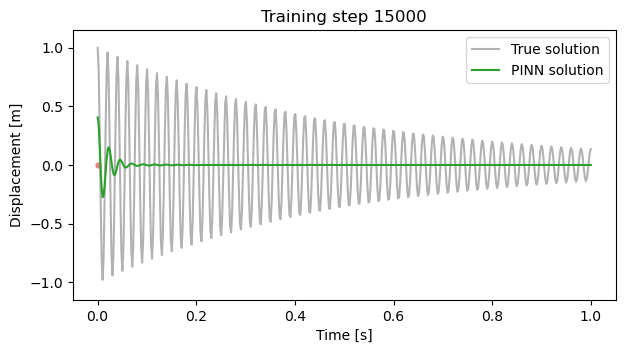

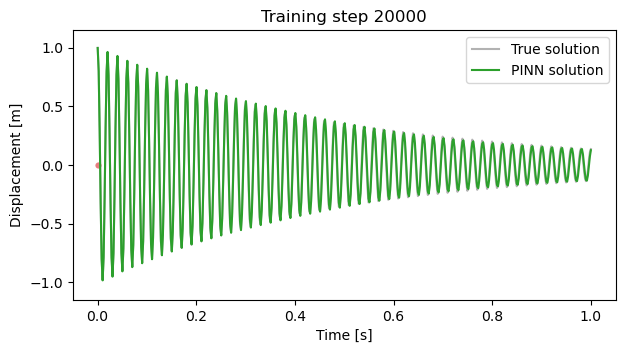

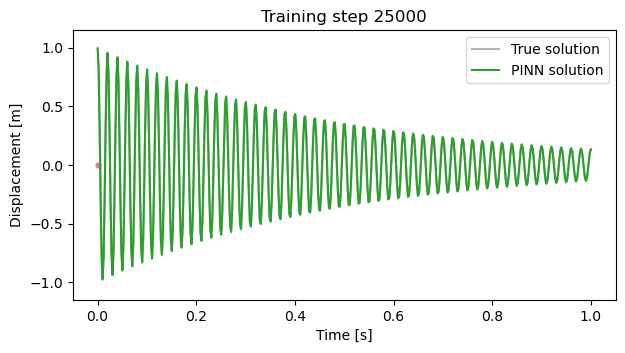

In [4]:
# ---------------------------------------------------------------------------*/
# - train this neural network

a = torch.nn.Parameter(180*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(1*torch.ones(1, requires_grad=True))

a_trace = []
b_trace = []

hyperparam_data, hyperparam_phys = 1e-1, 2e-7

opt_learningrate = 7e-3
opt_params = pinn.parameters + [a, b]
opt = torch.optim.Adam(opt_params, lr=opt_learningrate)

epochs = 25001

for epoch in range(epochs):
    opt.zero_grad()

    # compute data loss
    u = pinn(t_init) * torch.sin(a*t_init + b)
    loss_data_pos = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_init, torch.ones_like(u), create_graph=True)[0]
    loss_data_vel = (torch.squeeze(dudt) - 0)**2

    # compute physics loss
    u = pinn(t_phys) * torch.sin(a*t_phys + b)
    dudt = torch.autograd.grad(u, t_phys, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_phys, torch.ones_like(dudt), create_graph=True)[0]
    loss_phys = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # backpropagate joint loss, take optimiser step
    loss = loss_data_pos + hyperparam_data*loss_data_vel + hyperparam_phys*loss_phys
    loss.backward()
    opt.step()

    a_trace.append(a.item())
    b_trace.append(b.item())

    # plot intermediate results as training progresses
    if epoch % 5000 == 0:
        u = (pinn(t_test) * torch.sin(a*t_test + b)).detach()

        plt.figure(figsize=(7, 3.5))
        plt.scatter(t_init.detach()[:, 0], torch.zeros_like(t_init)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], u_true[:, 0], label="True solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.ylim([-1.15, 1.15])
        plt.title(f"Training step {epoch}")
        plt.xlabel("Time [s]")
        plt.ylabel("Displacement [m]")
        plt.legend()
        #plt.savefig(f'fig/pinn_play_sim_step_{epoch}.svg')
        plt.show()


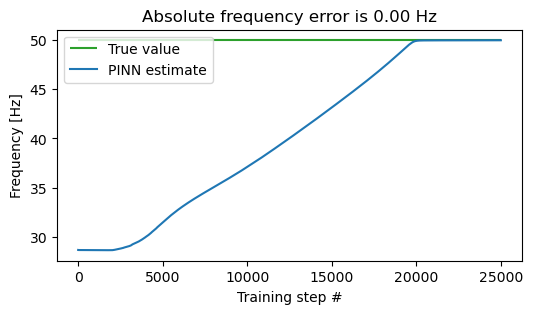

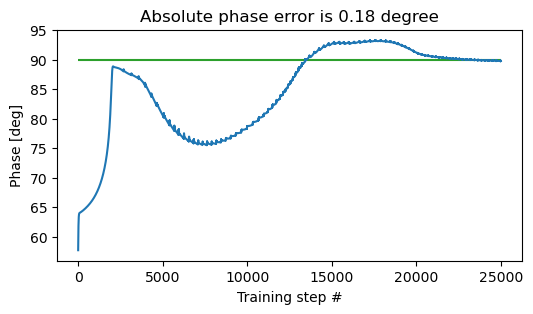

In [5]:
# ---------------------------------------------------------------------------*/
# - show identified system parameters

f0 = w0/(2*np.pi)
f_err = np.abs(f0 - a_trace[-1]/(2*np.pi))

plt.figure(figsize=(6, 3))
plt.title(f"Absolute frequency error is {f_err:.2f} Hz")
plt.hlines(f0, 0, len(a_trace), label="True value", color="tab:green")
plt.plot(np.asarray(a_trace)/(2*np.pi), label="PINN estimate")
plt.xlabel("Training step #")
plt.ylabel("Frequency [Hz]")
plt.legend()
plt.show()

phi0 = 90.
phi_err = np.abs(phi0 - np.rad2deg(b_trace[-1]))

plt.figure(figsize=(6, 3))
plt.title(f"Absolute phase error is {phi_err:.2f} degree")
plt.hlines(phi0, 0, len(b_trace), label="True value", color="tab:green")
plt.plot(torch.rad2deg(torch.tensor(b_trace)))
plt.xlabel("Training step #")
plt.ylabel("Phase [deg]")
plt.show()